# Sentiment Analysis

**Machine Learning Model**
- TF-IDF+Random Forest--> 67%
- TF-IDF+Logistic Regression --> 72%
- Glove+Random Forest --> 84% (Balance Precision,Recall)
- Glove+Logistic Regression --> 83% (Balance Precision,Recall)

**Deep Learning Model**
- Glove + Artificial Neural Network--> 83% (balance Precision,Recall)
- Glove + LSTM -->

**Train Test Spilt**
- x_train,x_test,y_train,y_test --> TF-IDF
- x1_train,x1_test,y1_train,y1_test --> Glove (Document(sentence) Level emabedding of the review)
- x2_train,x2_test,y2_train,y2_test --> Glove(Word Level emabedding of the review)

large dataset(IMBD Dataset) -- https://tinyurl.com/48u222dc

Dataset(imbd_reviews) -- https://tinyurl.com/ymemuumv

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Itvedant/NLP/imdb_reviews1.txt",sep='\t',header=None)

In [ ]:
data.columns=['review','sentiment']

In [ ]:
data.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [ ]:
data.shape

(748, 2)

Checking dataset is balanced or not

In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
1,386
0,362


In [ ]:
data['review'][3]

'Very little music or anything to speak of.  '

# Data Preprocessing

Find the null/missing values

In [ ]:
data.isna().sum()

,0
review,0
sentiment,0


Finding the duplicates in the data

In [ ]:
data.duplicated().sum()

np.int64(3)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.duplicated().sum()

np.int64(0)

# Preprocessing of the Reviews

Function of Preprocessing

In [ ]:
import nltk
import re

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
stop_words=nltk.corpus.stopwords.words('english')

This function used in Lemmatizer for context

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [ ]:
from nltk.stem import WordNetLemmatizer
ln=WordNetLemmatizer()

In [ ]:
def text_preprocessing(text):
  #HTML Parsing
  soup=BeautifulSoup(text,'html.parser')
  text=soup.get_text()                      #remove html tags
  text=re.sub(r'(\r\n|\n|\r)+','\n',text)   #substitute multiple lines and tabs into one
  #special words and symbols removal
  text=re.sub(r'[^a-zA-Z0-9\s]','',text)
  text=text.lower()
  text=text.strip()
  #tokenization breaking the text into tokens
  tokens=nltk.word_tokenize(text)
  #POS tagging
  tagged_tokens=nltk.pos_tag(tokens)
  #lemmatization
  lem_tokens=[ln.lemmatize(word,get_wordnet_pos(tag)) for word,tag in tagged_tokens]
  #stop words removal
  filter_tokens=[i for i in lem_tokens if i not in stop_words]
  filtered_text=" ".join(filter_tokens)
  return filtered_text



In [ ]:
data['pre_review']=data['review'].apply(lambda x:text_preprocessing(x))

In [ ]:
data.head()

,review,sentiment,pre_review
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless movie distressed drifting y...
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...
2,Attempting artiness with black & white and cle...,0,attempt artiness black white clever camera ang...
3,Very little music or anything to speak of.,0,little music anything speak
4,The best scene in the movie was when Gerardo i...,1,best scene movie gerardo try find song keep ru...


# EDA : Wordcloud visualization

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Positive Review

In [ ]:
text_pos=" ".join(data[data['sentiment']==1]['pre_review'])

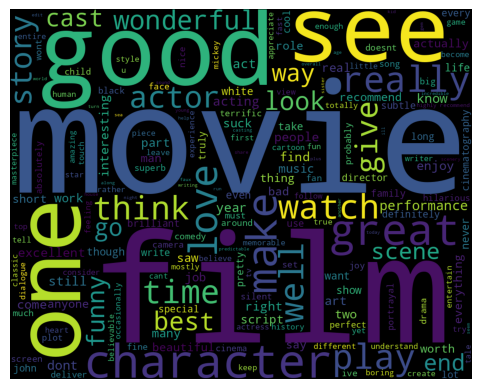

In [ ]:
wc=WordCloud(width=1000,height=800).generate(text_pos)
plt.imshow(wc)
plt.axis("off")
plt.show()

Negative Review

In [ ]:
text_neg=" ".join(data[data['sentiment']==0]['pre_review'])

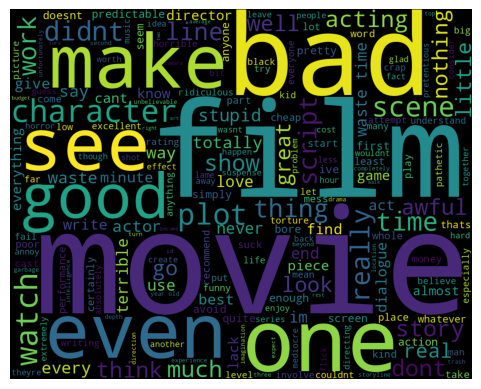

In [ ]:
wc=WordCloud(width=1000,height=800).generate(text_neg)
plt.imshow(wc)
plt.axis("off")
plt.show()

# Text Representation Technique

# Statistical method
## 1) TF-IDF Feature extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [ ]:
x=data['pre_review']
y=data['sentiment']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((596,), (596,), (149,), (149,))

### Random Forest Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pp=Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('classifier_rf',RandomForestClassifier())])

In [ ]:
classifier_rf=pp.fit(x_train,y_train)

In [ ]:
prediction_rf=classifier_rf.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
print("Confusion matrix",confusion_matrix(y_test,prediction_rf))
print("\n")
print(classification_report(y_test,prediction_rf))

Confusion matrix [[55 18]
 [35 41]]


              precision    recall  f1-score   support

           0       0.61      0.75      0.67        73
           1       0.69      0.54      0.61        76

    accuracy                           0.64       149
   macro avg       0.65      0.65      0.64       149
weighted avg       0.65      0.64      0.64       149



### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pp=Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('Logistic_Regression',LogisticRegression(solver='liblinear'))])

In [ ]:
classifier_logr=pp.fit(x_train,y_train)

In [ ]:
prediction_logr=classifier_logr.predict(x_test)

In [ ]:
print("Confusion matrix",confusion_matrix(y_test,prediction_logr))
print("\n")
print(classification_report(y_test,prediction_logr))

Confusion matrix [[43 30]
 [11 65]]


              precision    recall  f1-score   support

           0       0.80      0.59      0.68        73
           1       0.68      0.86      0.76        76

    accuracy                           0.72       149
   macro avg       0.74      0.72      0.72       149
weighted avg       0.74      0.72      0.72       149



# 2) Glove Embedding

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp=spacy.load('en_core_web_lg')

We build sentence level 300D vector

In [ ]:
def get_vec(x):
  doc=nlp(x)
  vector=doc.vector  #generate 300D vector (pure senetence ka vector)
  return vector

In [ ]:
data['glove']=data['pre_review'].apply(lambda x: get_vec(x))

In [ ]:
data.head()

,review,sentiment,pre_review,glove
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless movie distressed drifting y...,"[0.033679284, -0.07567986, -0.16047786, 0.0005..."
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...,"[0.15441644, 0.28305253, -0.13184263, 0.083682..."
2,Attempting artiness with black & white and cle...,0,attempt artiness black white clever camera ang...,"[-0.26978555, -0.02390889, -0.07035084, -0.092..."
3,Very little music or anything to speak of.,0,little music anything speak,"[-0.1412375, 0.3050325, -0.23658249, 0.2413775..."
4,The best scene in the movie was when Gerardo i...,1,best scene movie gerardo try find song keep ru...,"[0.022042409, 0.052952696, -0.09658201, -0.109..."


In [ ]:
data['glove'][0].shape

(300,)

In [ ]:
x=np.vstack(data['glove'].values)

In [ ]:
x.shape

(745, 300)

In [ ]:
y=data['sentiment']

In [ ]:
y.shape

(745,)

In [ ]:
x1_train,x1_test,y1_train,y1_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x1_train.shape,y1_train.shape,x1_test.shape,y1_test.shape

((596, 300), (596,), (149, 300), (149,))

Random Forest Model

In [ ]:
glove_RF=RandomForestClassifier()

In [ ]:
glove_RF.fit(x1_train,y1_train)

RandomForestClassifier()

In [ ]:
y_pred=glove_RF.predict(x1_test)

In [ ]:
print(classification_report(y1_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        73
           1       0.87      0.82      0.84        76

    accuracy                           0.85       149
   macro avg       0.85      0.85      0.85       149
weighted avg       0.85      0.85      0.85       149



Plotting Confusion Matrix using HeatMap

In [ ]:
cm=confusion_matrix(y1_test,y_pred)

In [ ]:
import seaborn as sns

<Axes: >

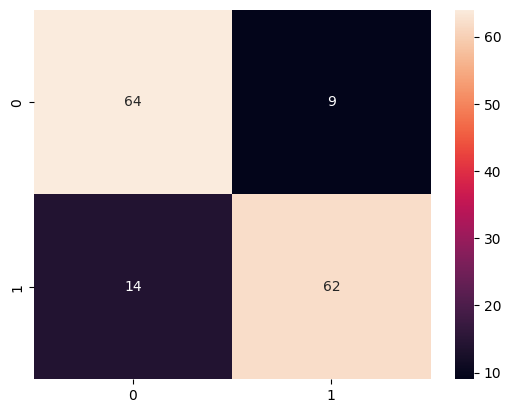

In [ ]:
sns.heatmap(cm,annot=True)

Logistic Regression Model

In [ ]:
glove_logr=LogisticRegression()

In [ ]:
glove_logr.fit(x1_train,y1_train)

LogisticRegression()

In [ ]:
y_pred=glove_logr.predict(x1_test)

In [ ]:
print(classification_report(y1_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        73
           1       0.82      0.84      0.83        76

    accuracy                           0.83       149
   macro avg       0.83      0.83      0.83       149
weighted avg       0.83      0.83      0.83       149



<Axes: >

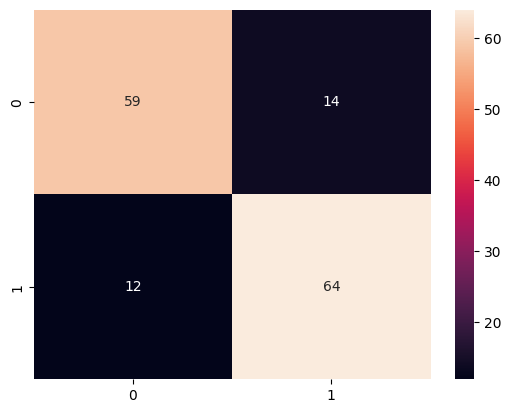

In [ ]:
sns.heatmap(confusion_matrix(y1_test,y_pred),annot=True)

# Deep Learning Model

##1) Glove + Artificial Neural Network

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
model=Sequential()
# Input Layer
model.add(Dense(256,activation='relu',input_dim=x.shape[1]))

#Hidden Layers
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.4))
model.add(BatchNormalization())


#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.4))

# Output Layer
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,593 (432.00 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(x1_train,y1_train,batch_size=4,epochs=30,validation_data=(x1_test,y1_test))

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7053 - loss: 0.6064 - val_accuracy: 0.7785 - val_loss: 0.5240
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8306 - loss: 0.3980 - val_accuracy: 0.8121 - val_loss: 0.4144
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8138 - loss: 0.4297 - val_accuracy: 0.7517 - val_loss: 0.4620
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8441 - loss: 0.3804 - val_accuracy: 0.7718 - val_loss: 0.4317
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8283 - loss: 0.3423 - val_accuracy: 0.7785 - val_loss: 0.5698
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8450 - loss: 0.3349 - val_accuracy: 0.7919 - val_loss: 0.4800
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8753 - loss: 0.3074 - val_accuracy: 0.7987 - val_loss: 0.4643
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8330 - loss: 0.3622 - val_accuracy: 0.

In [ ]:
y_pred=model.predict(x1_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
y_pred[0:5]

array([[0.07716279],
       [0.04338891],
       [0.06259826],
       [0.96926147],
       [0.8771578 ]], dtype=float32)

In [ ]:
y_pred=(y_pred>=0.5).astype(int)

In [ ]:
y_pred[0:5]

array([[0],
       [0],
       [0],
       [1],
       [1]])

In [ ]:
print(classification_report(y1_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        73
           1       0.82      0.83      0.82        76

    accuracy                           0.82       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.82      0.82      0.82       149



Confusion matrix

<Axes: >

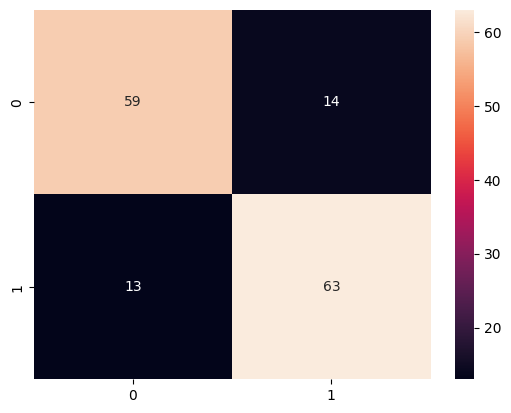

In [ ]:
sns.heatmap(confusion_matrix(y1_test,y_pred),annot=True)

##2) Glove + LSTM

LSTM's :
- The Input is always #D in nature
- Word Level emabedding of the review ("This is bad movie" --> "bad movie")

In [ ]:
def get_vect(x):
  doc=nlp(x)
  vecs=[tok.vector for tok in doc]
  return np.array(vecs,dtype=np.float32)

In [ ]:
data['word_glove']=data['pre_review'].apply(lambda x: get_vect(x))

In [ ]:
data.head()

,review,sentiment,pre_review,glove,word_glove
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless movie distressed drifting y...,"[0.033679284, -0.07567986, -0.16047786, 0.0005...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...,"[0.15441644, 0.28305253, -0.13184263, 0.083682...","[[0.040567, 0.21175, -0.59301, -0.053492, 0.11..."
2,Attempting artiness with black & white and cle...,0,attempt artiness black white clever camera ang...,"[-0.26978555, -0.02390889, -0.07035084, -0.092...","[[-0.24352, -0.24027, -0.171, 0.32326, -0.5709..."
3,Very little music or anything to speak of.,0,little music anything speak,"[-0.1412375, 0.3050325, -0.23658249, 0.2413775...","[[-0.4716, 0.25148, -0.36664, 0.32902, 0.07374..."
4,The best scene in the movie was when Gerardo i...,1,best scene movie gerardo try find song keep ru...,"[0.022042409, 0.052952696, -0.09658201, -0.109...","[[-0.51704, 0.32636, 0.13205, -0.2452, 0.45463..."


In [ ]:
data['pre_review'][1]

'sure lost flat character audience nearly half walk'

In [ ]:
data['word_glove'][1].shape

(8, 300)

In [ ]:
data['pre_review'][3]

'little music anything speak'

In [ ]:
data['word_glove'][3].shape

(4, 300)

Goal is to become x as 3D
- X=(sample,max_len,emd_dim)
- X=(745,50,300)

In [ ]:
max_len=50
emd_dim=300

In [ ]:
x=np.zeros((len(data),max_len,300),dtype=np.float32)

In [ ]:
for i,vec in enumerate(data['word_glove']):
  length=min(len(vec),max_len)     # (no of words,max_len)
  x[i,:length,:]=vec[:length]

In [ ]:
x.shape

(745, 50, 300)

In [ ]:
y=data['sentiment']

In [ ]:
y.shape

(745,)

In [ ]:
x2_train,x2_test,y2_train,y2_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x2_train.shape,y2_train.shape,x2_test.shape,y2_test.shape

((596, 50, 300), (596,), (149, 50, 300), (149,))

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model2=Sequential([
    LSTM(128,input_shape=(max_len,emd_dim)),
    Dense(1,activation='sigmoid')
     ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,777 (858.50 KB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from gc import callbacks
callbacks=[EarlyStopping(patience=10,restore_best_weights=True)]

In [ ]:
model2.fit(x2_train,y2_train,batch_size=4,epochs=20,callbacks=callbacks,verbose=2,validation_data=(x2_test,y2_test))

Epoch 1/20
149/149 - 8s - 56ms/step - accuracy: 0.5000 - loss: 0.6955 - val_accuracy: 0.5101 - val_loss: 0.6929
Epoch 2/20
149/149 - 6s - 42ms/step - accuracy: 0.6577 - loss: 0.6329 - val_accuracy: 0.6980 - val_loss: 0.6180
Epoch 3/20
149/149 - 11s - 72ms/step - accuracy: 0.6913 - loss: 0.6166 - val_accuracy: 0.6309 - val_loss: 0.6403
Epoch 4/20
149/149 - 8s - 56ms/step - accuracy: 0.5604 - loss: 0.6609 - val_accuracy: 0.6443 - val_loss: 0.6352
Epoch 5/20
149/149 - 7s - 48ms/step - accuracy: 0.5872 - loss: 0.6838 - val_accuracy: 0.6913 - val_loss: 0.6180
Epoch 6/20
149/149 - 8s - 57ms/step - accuracy: 0.6560 - loss: 0.6437 - val_accuracy: 0.6577 - val_loss: 0.6291
Epoch 7/20
149/149 - 10s - 69ms/step - accuracy: 0.5487 - loss: 0.6847 - val_accuracy: 0.5101 - val_loss: 0.6933
Epoch 8/20
149/149 - 7s - 45ms/step - accuracy: 0.5218 - loss: 0.6893 - val_accuracy: 0.5101 - val_loss: 0.6932
Epoch 9/20
149/149 - 8s - 57ms/step - accuracy: 0.5218 - loss: 0.6886 - val_accuracy: 0.5101 - val_los

In [ ]:
y_pred=model2.predict(x2_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [ ]:
y_pred[0]

array([0.33347026], dtype=float32)

In [ ]:
y_pred=(y_pred>0.5).astype(int)

In [ ]:
y_pred[0]

array([0])

<Axes: >

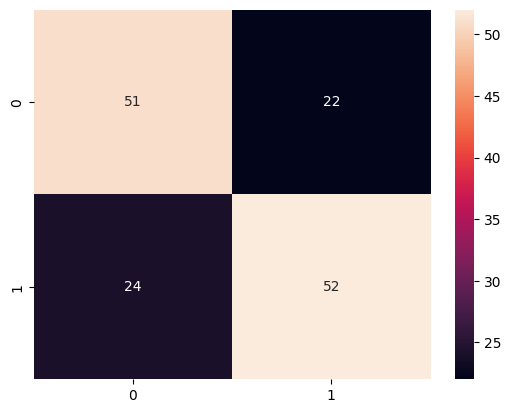

In [ ]:
sns.heatmap(confusion_matrix(y2_test,y_pred),annot=True)

In [ ]:
print(classification_report(y2_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        73
           1       0.70      0.68      0.69        76

    accuracy                           0.69       149
   macro avg       0.69      0.69      0.69       149
weighted avg       0.69      0.69      0.69       149



Refined LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional,GlobalMaxPool1D
from tensorflow.keras.layers import Embedding,Masking

In [ ]:
model3=Sequential([
    Masking(mask_value=0.0,input_shape=(max_len,emd_dim)),
    Bidirectional(LSTM(128,return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,809 (1.74 MB)

 Trainable params: 455,809 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from gc import callbacks
callbacks=[EarlyStopping(patience=10,restore_best_weights=True)]

In [ ]:
model3.fit(x2_train,y2_train,batch_size=4,epochs=20,callbacks=callbacks,verbose=2,validation_data=(x2_test,y2_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


149/149 - 17s - 117ms/step - accuracy: 0.7584 - loss: 0.4768 - val_accuracy: 0.8054 - val_loss: 0.4019
Epoch 2/20
149/149 - 13s - 85ms/step - accuracy: 0.8926 - loss: 0.2799 - val_accuracy: 0.8725 - val_loss: 0.3110
Epoch 3/20
149/149 - 25s - 167ms/step - accuracy: 0.9430 - loss: 0.1721 - val_accuracy: 0.8456 - val_loss: 0.3588
Epoch 4/20
149/149 - 18s - 120ms/step - accuracy: 0.9732 - loss: 0.1052 - val_accuracy: 0.8792 - val_loss: 0.3201
Epoch 5/20
149/149 - 19s - 125ms/step - accuracy: 0.9765 - loss: 0.0711 - val_accuracy: 0.8389 - val_loss: 0.3503
Epoch 6/20
149/149 - 14s - 94ms/step - accuracy: 0.9899 - loss: 0.0348 - val_accuracy: 0.8322 - val_loss: 0.5117
Epoch 7/20
149/149 - 26s - 171ms/step - accuracy: 0.9966 - loss: 0.0230 - val_accuracy: 0.8523 - val_loss: 0.4680
Epoch 8/20
149/149 - 13s - 86ms/step - accuracy: 0.9983 - loss: 0.0118 - val_accuracy: 0.8591 - val_loss: 0.5292
Epoch 9/20
149/149 - 17s - 111ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8591 - val_l

In [ ]:
y_pred=model3.predict(x2_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:
y_pred[0]

array([0.23632313], dtype=float32)

In [ ]:
y_pred=(y_pred>0.5).astype(int)

In [ ]:
y_pred[0]

array([0])

<Axes: >

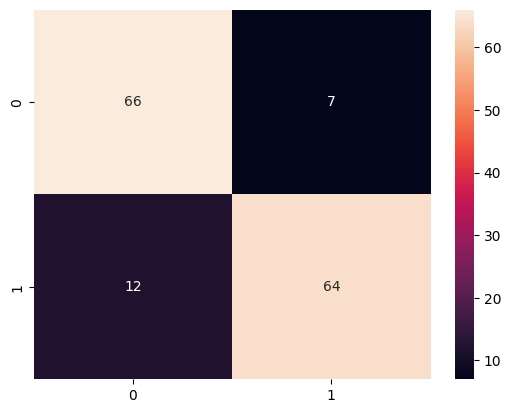

In [ ]:
sns.heatmap(confusion_matrix(y2_test,y_pred),annot=True)

In [ ]:
print(classification_report(y2_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        73
           1       0.90      0.84      0.87        76

    accuracy                           0.87       149
   macro avg       0.87      0.87      0.87       149
weighted avg       0.87      0.87      0.87       149



Till now the best model encontered is the refined LSTM

Save the model

In [ ]:
model3.save('glove_lstm_sentiment_analysis.h5')